In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


from sklearn import preprocessing, pipeline
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import time

from cfmining.algorithms import MAPOCAM, BruteForce, Greedy, ActionsEnumerator
from cfmining.criteria import PercentileCalculator, PercentileCriterion, PercentileChangesCriterion, NonDomCriterion
from cfmining.predictors import MonotoneClassifier
from cfmining.visualization import buildTable, FeatureImportance, PlotCounterfactuals
from cfmining.mip_builder import RecourseBuilder
from cfmining.action_set import ActionSet

In [2]:
import folium

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

# Read in the data

In [4]:
data_path = "../../SPdata/Dados_Tratados/base_de_dados.csv"
## load and process data
crime_df = pd.read_csv(data_path, index_col=0)#.reset_index(drop=True)
crime_df = crime_df.drop('Cluster', axis=1)
crime_df = crime_df.drop('Homicides', axis=1)
#crime_df = crime_df.drop('Favelas', axis=1)

crime_df['Population'] = crime_df['Population']/1000
crime_df['Passengers'] = crime_df['Passengers']/1000
crime_df['BusStops'] = crime_df['BusStops']/1000

### fixing values
crime_df['GarbageCollection'] = crime_df['GarbageCollection']/crime_df['GarbageCollection'].max()
crime_df['SewageCollection'] = crime_df['SewageCollection']/crime_df['SewageCollection'].max()
#crime_df['ImprovisedHousing'] = crime_df['ImprovisedHousing']/crime_df['ImprovisedHousing'].max()
crime_df[crime_df['ImprovisedHousing']>1]=1
crime_df['PermanentHousing'] = crime_df['PermanentHousing']/crime_df['PermanentHousing'].max()
crime_df['LiterateHouseHolder'] = crime_df['LiterateHouseHolder']/crime_df['LiterateHouseHolder'].max()
crime_df['WaterSupply'] = crime_df['WaterSupply']/crime_df['WaterSupply'].max()

raux = (crime_df['Crimes']/(1+crime_df['Population']))#[crime_df['POP10']>=100]
aaux = crime_df['Crimes']
Xaux = crime_df.drop('Crimes', axis=1)#[crime_df['POP10']>=100]


perc = 97
absolute=True
if absolute:
    y = (aaux<np.percentile(aaux, perc))
else:
    y = (raux<np.percentile(raux, perc))
ya = (aaux<np.percentile(aaux, perc))
yr = (raux<np.percentile(raux, perc))
r  = raux
a = aaux
X = Xaux

In [5]:
pd.set_option('display.max_columns', 30)
stats_df = pd.DataFrame(columns=crime_df.columns)
stats_df.loc['General'] = crime_df.mean()
stats_df.loc['Absolute'] = crime_df[~ya].mean()
stats_df.loc['Relative'] = crime_df[~yr].mean()
stats_df

,Passengers,TravelingTime,HighRiskAreas,FontainArea,ExpansionPhase,Population,Favelas,WaterSupply,HighIncomeHolder,LiterateHouseHolder,WomanHouseHolder,PopulationDensity,ImprovisedHousing,PermanentHousing,SewageCollection,GarbageCollection,YoungManRate,Verticalization,Bars,Schools,BusStops,Crimes
General,1.240959,34.387126,0.284335,0.105471,3.173218,0.605083,0.105471,0.873114,0.029433,0.891505,0.438488,2.499868,0.000831,0.942853,0.920428,0.912026,0.073570,0.263343,0.498760,0.361262,0.042993,53.203398
Absolute,1.892299,35.554130,0.137083,0.047452,2.355009,0.604587,0.003515,0.891609,0.033507,0.910543,0.435103,1.492091,0.002982,0.926698,0.923348,0.918093,0.060365,0.356381,3.483304,0.994728,0.394707,550.541301
Relative,1.868773,35.418278,0.128295,0.040422,2.381371,0.514494,0.003515,0.891344,0.034184,0.910397,0.438130,1.395431,0.002543,0.927443,0.923311,0.918008,0.060975,0.353825,3.623902,0.989455,0.389185,543.312830


In [6]:
plt.rcParams["figure.figsize"] = [6.0,4.0]

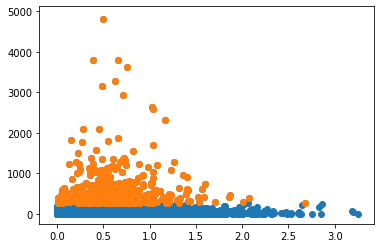

In [7]:
plt.scatter(crime_df['Population'], crime_df['Crimes'])
plt.scatter(crime_df['Population'][~ya], crime_df['Crimes'][~ya]);

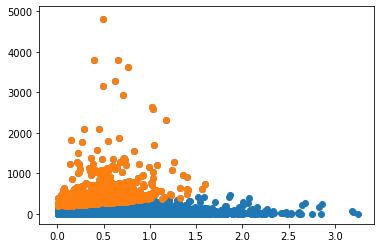

In [8]:
plt.scatter(crime_df['Population'], crime_df['Crimes'])
plt.scatter(crime_df['Population'][~yr], crime_df['Crimes'][~yr]);

In [9]:
sector_shapes = gpd.read_file("../../SPdata/Dados_Brutos/Marcelo/Setores/CEMEAI_1/PL_MSP_SETOR_10_CEM_pol.shp")
sector_shapes['CODSETOR'] = sector_shapes['CODSETOR'].astype(int)
sector_shapes = sector_shapes.set_index('CODSETOR', drop=False);

In [10]:
crime_indexes = crime_df[~y].index
crime_indexesr = crime_df[~yr].index
crime_indexesc = crime_df[~ya].index

In [11]:
syr = (~yr).reindex(sector_shapes.index).fillna(False)
plot_sector = sector_shapes.loc[syr,:]
crim_df_plot = crime_df.loc[~yr].reset_index().rename(columns={'index': 'CODSETOR'})
crim_df_plot['NOM_DI'] = [plot_sector.loc[idx, 'NOM_DI'] for idx in crim_df_plot['CODSETOR']]

In [12]:
fig = px.choropleth_mapbox(crim_df_plot, geojson=plot_sector, locations='CODSETOR', color='Crimes',
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
                           mapbox_style="carto-positron",
                           zoom=10, center = {"lat": -23.6, "lon": -46.55},
                           opacity=0.5,
                           hover_data = ['NOM_DI'],
                           labels={'Crimes':'Number of crimes', 
                                   'NOM_DI':'Region Name'}
                          )
fig = go.FigureWidget(fig)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#choices = []
#def update_point(trace, points, selector):
#    global choices
#    if len(choices)<3:
#        choices +=[crim_df_plot.iloc[points.point_inds[0],:]['CODSETOR']]
#        print('Choice number ',len(choices),':',choices[-1], plot_sector.loc[choices[-1], 'NOM_DI'])
#        print(clf_logreg.predict_proba([X.loc[choices[-1]].values])[:, 1])
#    else:
#        print('All choices made')
#fig.data[0].on_click(update_point)

fig

FigureWidget({
    'data': [{'coloraxis': 'coloraxis',
              'customdata': array([['ALTO DE PINHEIROS'…

In [13]:
random_state = 1762#np.random.randint(10000)
Xtr, Xts, ytr, yts, rtr, rts, ctr, cts = train_test_split(X, y, r, a, test_size=100, random_state=random_state)

# Train model

Ok great, now let's get into the meat of it. Let's train up a model as see what recourse exists.

In [14]:
## grid search
stand = preprocessing.StandardScaler()
clf_base = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs')
clf = pipeline.Pipeline([('std', stand), ('clf', clf_base)])

grid = GridSearchCV(
  clf, param_grid={'clf__C': np.logspace(-10, 10)},
  cv=5,
  scoring='roc_auc',
  verbose=0
)

grid.fit(Xtr, ytr)
clf_logreg = grid.best_estimator_

In [15]:
print('AUC performance:', roc_auc_score(yts, clf_logreg.predict(Xts)))

AUC performance: 0.8578947368421054


## Preparing classifiers to be actionable

In [16]:
clf_logreg_ = MonotoneClassifier(clf_logreg, Xtr, ytr, threshold=0.8)
coefficients = clf_logreg['clf'].coef_[0]/clf_logreg['std'].scale_
intercept = clf_logreg['clf'].intercept_[0]-coefficients@clf_logreg['std'].mean_

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

/home/marcos/Documents/Experiments/envs/crime/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.



## Preparing action set

In [17]:
action_set = ActionSet(X = X)
action_set.embed_linear_clf(coefficients=coefficients)
for feat in action_set:
    if feat.name in ['HighRiskAreas', 'FontainArea', 'ExpansionPhase', 'PopulationDensity']:
        feat.step_type ="absolute"
        feat.step_size = 1
    elif feat.name in ['ImprovisedHouse', 'WaterSupply', 'PermanentHouse', 'SewageCollection',
                       'GarbageCollection', 'WomanHouseHolder', 'YoungManRate', 'Verticalization']:
        feat.step_type ="relative"
        feat.step_size = 1/6
    else:
        feat.step_type ="relative"
        feat.step_size = 0.1
    feat.update_grid()

In [18]:
pd_coef = pd.Series(coefficients, index=X.columns).to_frame('Coefficients')
pd_coef

,Coefficients
Passengers,-0.403762
TravelingTime,-0.003363
HighRiskAreas,0.018377
FontainArea,0.435443
ExpansionPhase,0.404366
Population,-0.724454
Favelas,1.006129
WaterSupply,0.079228
HighIncomeHolder,4.873752
LiterateHouseHolder,0.510315


## Preparing sample to be actionable

In [19]:
scores = pd.Series(clf_logreg.predict_proba(X)[:, 1], index=X.index)
denied_individuals = scores.loc[lambda s: (s < .79)&(s > .7)].index

In [20]:
choices = [355030846000242, 355030810000012, 355030862000053]

In [21]:
choice = 355030846000242
#choice = choices[1]
#choice = np.random.choice(denied_individuals)
individual = X.loc[choice].values

## Preparing criteria

In [22]:
percCalc = PercentileCalculator(action_set=action_set)
percCriteria = PercentileCriterion(individual, percCalc)
percChCriteria = PercentileChangesCriterion(individual, percCalc)

## Generate original recourse

In [23]:
p = .8
rb = RecourseBuilder(
      optimizer="cplex",
      coefficients=coefficients,
      intercept=intercept- (np.log(p / (1. - p))),
      action_set=action_set,
      x=np.array(individual)
)

build_info, indices = rb._get_mip_build_info()
output_1 = rb.fit()

In [24]:
print('Number of actions', sum(output_1['actions']!=0))
pd.Series(output_1['actions'], index=X.columns).to_frame('Actions')

Number of actions 2


,Actions
Passengers,0.000000
TravelingTime,0.000000
HighRiskAreas,1.000000
FontainArea,0.000000
ExpansionPhase,-0.000000
Population,0.000000
Favelas,-0.000000
WaterSupply,-0.000000
HighIncomeHolder,0.000000
LiterateHouseHolder,0.000000


## Enumerate recourse

In [25]:
en_nd_feat = MAPOCAM(action_set, individual, clf_logreg_, max_changes=3, recursive=True)
start = time.perf_counter()
en_nd_feat.fit()
print('Elapsed time:', time.perf_counter()-start)

Elapsed time: 0.12684599682688713


## Recourses summary

In [26]:
names = action_set.df['name'].values
overview_clean = buildTable(en_nd_feat, individual, percCriteria, names, include_original=False, include_cost=False)
overview_full = buildTable(en_nd_feat, individual, percCriteria, names, include_original=True, include_cost=True)

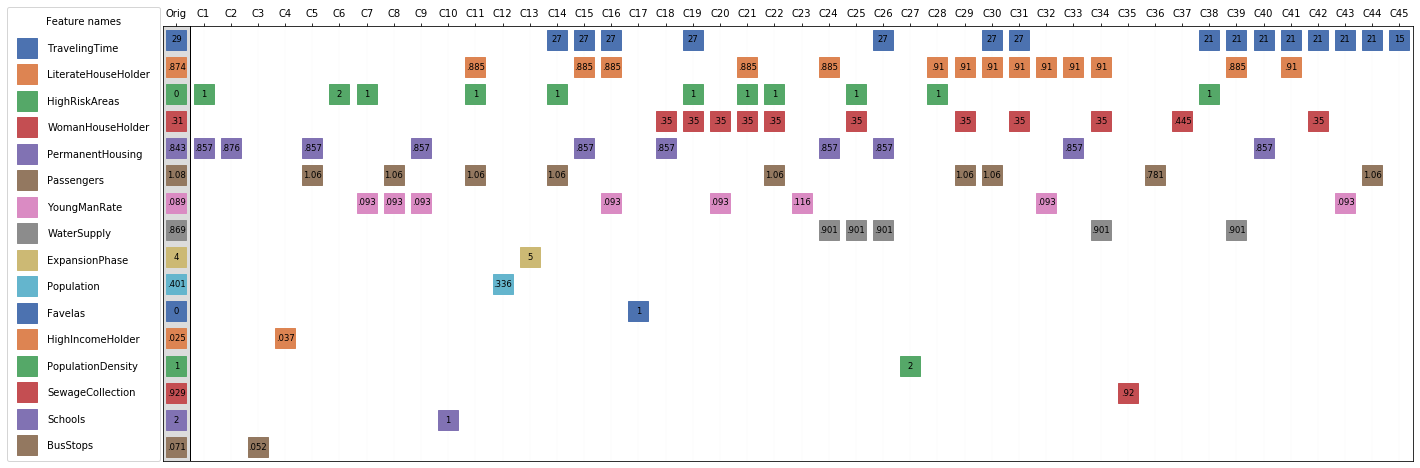

In [27]:
pltW = PlotCounterfactuals(overview_clean.iloc[:,:], individual)
pltW.show('plot/feature_nondom_enum_crime.pdf')

## Constrained action set

In [28]:
constr_action_set = ActionSet(X = X)
constr_action_set.embed_linear_clf(coefficients=coefficients)
for feat in constr_action_set:
    if feat.name in ['HighRiskAreas', 'FontainArea', 'ExpansionPhase', 'PopulationDensity']:
        feat.step_type ="absolute"
        feat.step_size = 1
    elif feat.name in ['ImprovisedHouse', 'WaterSupply', 'PermanentHouse', 'SewageCollection', 'GarbageCollection', 'WomanHouseHolder', 'YoungManRate', 'Verticalization']:
        feat.step_type ="relative"
        feat.step_size = 1/6
    else:
        feat.step_type ="relative"
        feat.step_size = 0.1
    feat.update_grid()

for feat in constr_action_set:
    if feat.name in ['Bars', 'BusStops', 'Schools', 'ExpansionPhase']:
        feat.mutable = False
        feat.step_direction = 1
    if feat.name in ['HighRiskAreas', 'FontainArea', 'ImprovisedHouse', 'TravelTime', 'Favelas']:
        feat.mutable = True
        feat.step_direction = -1
    if feat.name in ['WaterSupply', 'SewageCollection', 'GarbageCollection', 'PermanentHouse', 'HighIncomeHolder']:
        feat.mutable = True
        feat.step_direction = 1
    if feat.name in ['Population', 'WomanHouseHolder', 'PopulationDensity', 'YoungManRate', 'Verticalization']:
        feat.step_direction = feat.flip_direction
    if feat.step_direction!=feat.flip_direction:
        feat.mutable = False
    
    feat.update_grid()

## Enumerate recourse

In [29]:
en_nd_feat_const = MAPOCAM(constr_action_set, individual, clf_logreg_, max_changes=3, recursive=True)
start = time.perf_counter()
en_nd_feat_const.fit()
print('Elapsed time:', time.perf_counter()-start)

Elapsed time: 0.07096275594085455


## Recourses summary

In [30]:
names = action_set.df['name'].values
overview_clean = buildTable(en_nd_feat_const, individual, percCriteria, names, include_original=False, include_cost=False)
overview_full = buildTable(en_nd_feat_const, individual, percCriteria, names, include_original=True, include_cost=True)

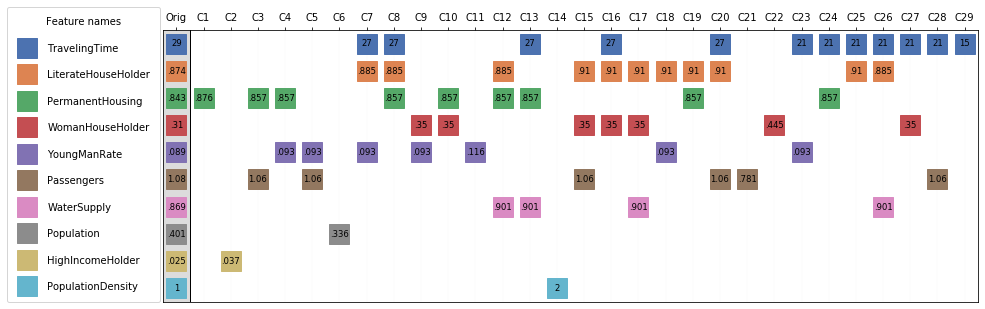

In [31]:
pltW = PlotCounterfactuals(overview_clean.iloc[:,:], individual)
pltW.show('plot/feature_nondom_enum_crime_const.pdf')

## Importance level

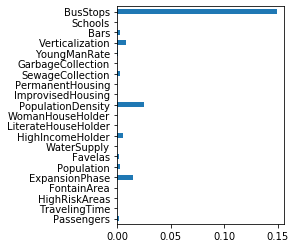

In [32]:
plt.rcParams["figure.figsize"] = [3.0,4.0]
#importance =  pd.Series(abs(coefficients), index=X.columns)*X.std(axis=0)
importance =  pd.Series(clf_logreg_.importances, index=X.columns)#*X.std(axis=0)
colors = ['#1f78b4' for i in range(importance.size)]
ax = importance.plot.barh(color=colors)
ax.figure.savefig('plot/importance_logistic.eps', bbox_inches='tight')

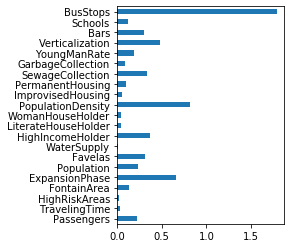

In [33]:
plt.rcParams["figure.figsize"] = [3.0,4.0]
importance =  pd.Series((abs(coefficients)*X.std(axis=0)), index=X.columns)
#importance =  pd.Series(clf_logreg_.importances, index=X.columns)*X.std(axis=0)
colors = ['#1f78b4' for i in range(importance.size)]
ax = importance.plot.barh(color=colors)
ax.figure.savefig('plot/importance_logistic.eps', bbox_inches='tight')

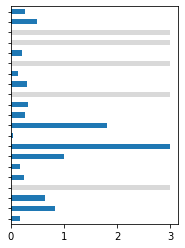

In [34]:
#choice = np.random.choice(denied_individuals)
#individual = X.loc[choice].values
enum = MAPOCAM(action_set, individual, clf_logreg_, max_changes=3, recursive=True)
enum.fit()
over = FeatureImportance(enum, individual, action_set)
ax = over.show('plot/importance_changes_r1.eps')

Choice: 355030810000012


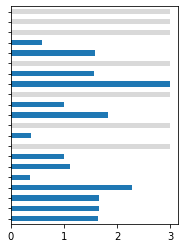

In [35]:
choice = choices[1]
print('Choice:', choice)
new_individual = X.loc[choice].values
enum = MAPOCAM(action_set, new_individual, clf_logreg_, max_changes=3, recursive=True)
enum.fit()
over = FeatureImportance(enum, new_individual, action_set)
over.show('plot/importance_changes_r2.eps')

Choice: 355030862000053


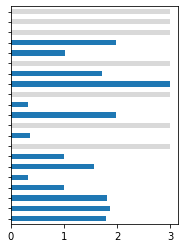

In [36]:
choice = choices[2]
print('Choice:', choice)
new_individual = X.loc[choice].values
enum = MAPOCAM(action_set, new_individual, clf_logreg_, max_changes=3, recursive=True)
enum.fit()
over = FeatureImportance(enum, new_individual, action_set)
over.show('plot/importance_changes_r3.eps')